### 과제
* 전이 학습으로 강아지와 고양이 구분하기
* https://www.kaggle.com/c/dogs-vs-cats
* https://www.kaggle.com/datasets/tongpython/cat-and-dog

In [1]:
import os

In [2]:
os.environ['KAGGLE_USERNAME'] = 'koduri135'
os.environ['KAGGLE_KEY'] = 'f21f542a22adb7f43c15dc144f512c7a'

In [3]:
!kaggle datasets download -d pmigdal/alien-vs-predator-images
!unzip -q alien-vs-predator-images.zip

 85% 12.0M/14.1M [00:01<00:00, 12.0MB/s]
100% 14.1M/14.1M [00:01<00:00, 8.82MB/s]


In [4]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


In [ ]:
!kaggle datasets download -d tongpython/cat-and-dog
!unzip -q cat-and-dog.zip

 73% 160M/218M [00:08<00:02, 24.0MB/s]

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomAffine(0, shear=10, scale=(0.8, 1.2)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'validation': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
}

In [ ]:
def target_transforms(target):
  return torch.FloatTensor([target])


In [ ]:
image_datasets = {
    'train': datasets.ImageFolder('/content/training_set/training_set', data_transforms['train'], target_transform=target_transforms),
    'validation': datasets.ImageFolder('/content/test_set', data_transforms['validation'], target_transform=target_transforms)
}

dataloaders = {
    'train': DataLoader(
        image_datasets['train'],
        batch_size= 32,
        shuffle=True
    ),
    'validation': DataLoader(
        image_datasets['train'],
        batch_size= 32,
        shuffle=False
    )
}

print(len(image_datasets['train']), len(image_datasets['validation']))

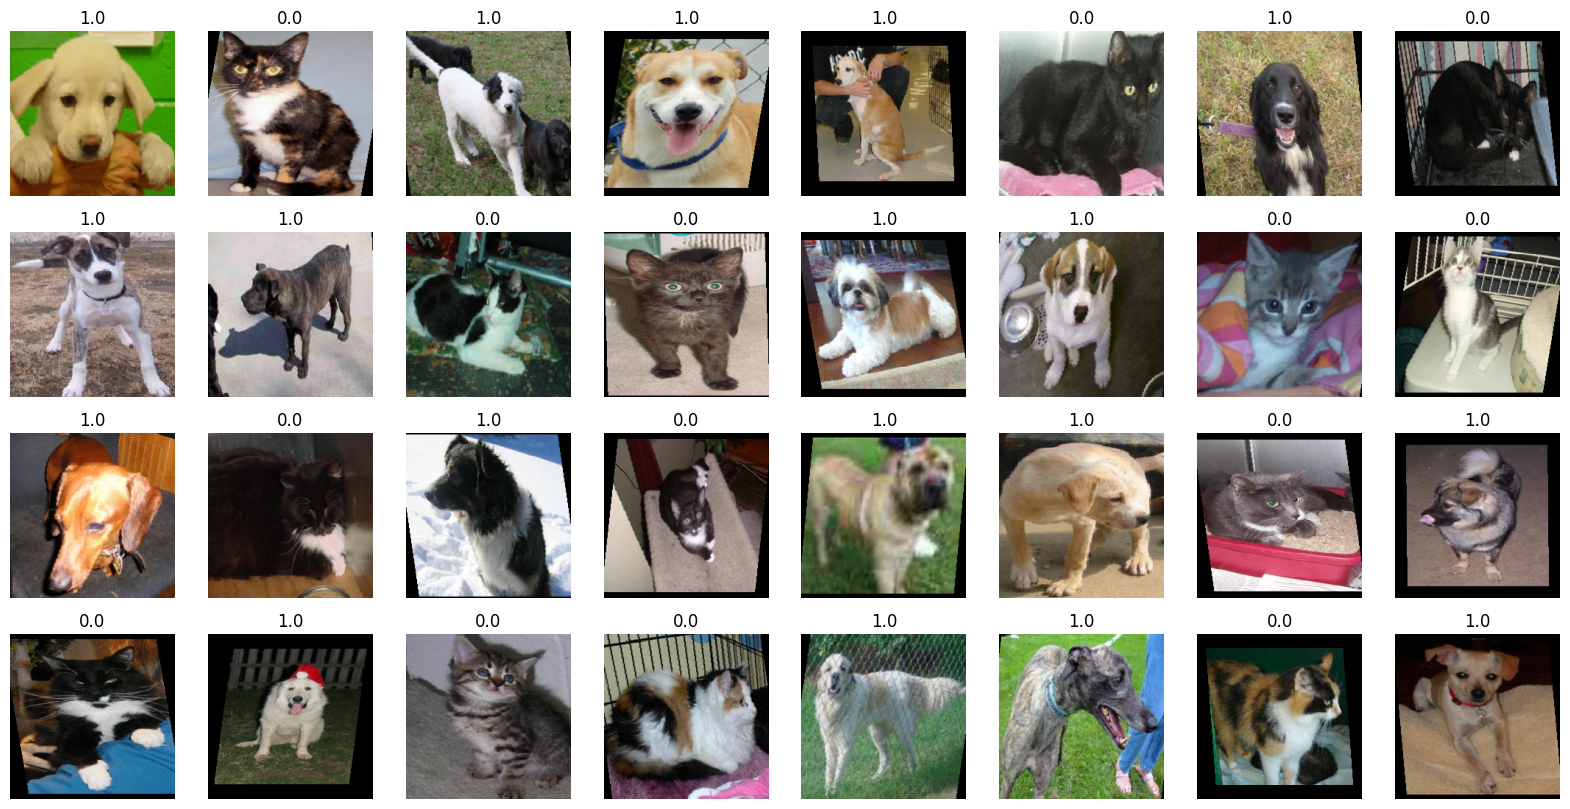

In [ ]:
imgs, labels = next(iter(dataloaders['train']))

fig, axes = plt.subplots(4, 8, figsize=(20, 10))

for ax, img, label in zip(axes.flatten(), imgs, labels):
    ax.imshow(img.permute(1, 2, 0))
    ax.set_title(label.item())
    ax.axis('off')

In [ ]:
model = models.resnet50(weights='IMAGENET1K_V1').to(device) #이미지넷을미리 학습후에 가져온다
print(model)

In [ ]:
for param in model.parameters():
  param.requires_grad = False # 가져온 파라미터(W, b)를 업데이터하지 않음

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

print(model)

In [ ]:
# 학습: fc 부분만 학습하므로 속도가 빠름

optimizer = optim.Adam(model.fc.parameters(), lr=0.001)
epochs = 10
for epoch in range(epochs):
    for phase in ['train', 'validation']:
        if phase == 'train':
            model.train()
        else:
            model.eval()
        sum_losses = 0
        sum_accs = 0
        for x_batch, y_batch in dataloaders[phase]:
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)

            y_pred = model(x_batch)
            loss = nn.BCELoss()(y_pred, y_batch)

            if phase == 'train':
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            sum_losses = sum_losses + loss.item()

            y_bool = (y_pred >= 0.5).float()
            acc = (y_batch == y_bool).float().sum() / len(y_batch) * 100
            sum_accs = sum_accs + acc.item()

        avg_loss = sum_losses / len(dataloaders[phase])
        avg_acc = sum_accs / len(dataloaders[phase])

        print(f'{phase:10s}: Epoch {epoch+1:4d}/{epochs}, Loss: {avg_loss:.4f}, Accuracy: {avg_acc:.2f}%')

In [ ]:
torch.save(model.state_dict(),'model.h6')

In [ ]:
model = models.resnet50().to(device)

model.fc = nn.Sequential(
    nn.Linear(2048, 128),
    nn.ReLU(),
    nn.Linear(128, 1),
    nn.Sigmoid()
).to(device)

In [ ]:
# 모델 로드
model.load_state_dict(torch.load('model.h6'))
model.eval()

In [ ]:
# 테스트
from PIL import Image

img1 = Image.open('/content/test_set/test_set/cats/cat.4113.jpg')
img2 = Image.open('/content/test_set/test_set/dogs/dog.4157.jpg')

fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()

In [ ]:
img1_input = data_transforms['validation'](img1)
img2_input = data_transforms['validation'](img2)

print(img1_input.shape)
print(img2_input.shape)

In [ ]:
test_batch = torch.stack([img1_input, img2_input])
test_batch = test_batch.to(device)
test_batch.shape

In [ ]:
y_pred = model(test_batch)
y_pred

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
axes[0].set_title(f'{(1-y_pred[0, 0]) * 100:.2f}% Cat, {y_pred[0, 0] * 100:.2f}% Dog')
axes[0].imshow(img1)
axes[0].axis('off')
axes[1].set_title(f'{(1-y_pred[1, 0]) * 100:.2f}% Cat, {y_pred[1, 0] * 100:.2f}% Dog')
axes[1].imshow(img2)
axes[1].axis('off')
plt.show()